## Introduction
In this notebook WRN-101-2 model is created and trained on the chest x-ray dataset to classify whether an image shows signs of pneumonia or not. Model is trained using the best configuration identified in WRN-50-2 experiments.

Model is evaluated for performance metrics on test data. Finally model is incorporated with Score-CAM interpretability technique.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Optional: If processed.zip is downloaded from google drive link
Unzip the pre processed dataset zip file, located in google drive at https://drive.google.com/file/d/1pjMCimi8fs1W0ccrwF4nkP0vKUYG_szR/view?usp=sharing

In [ ]:
!unzip -u "/content/drive/MyDrive/processed.zip" -d "/content/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/processed/train/1/7cf4a9ef-0192-432d-bcf4-b4f8ebb3704a.npy  
  inflating: /content/processed/train/1/7d1b94bf-9fb6-4191-bf69-09549b4a3b96.npy  
  inflating: /content/processed/train/1/7d3b3dd0-2fa5-43dc-a84b-673bc0eebaa7.npy  
  inflating: /content/processed/train/1/7d3f2d28-c21b-4a64-940c-c635176f35e1.npy  
  inflating: /content/processed/train/1/7d402380-193a-4aef-92aa-8c80e11217fb.npy  
  inflating: /content/processed/train/1/7d5f828f-5c6a-4898-a64f-8364339f35cd.npy  
  inflating: /content/processed/train/1/7d674c82-5501-4730-92c5-d241fd6911e7.npy  
  inflating: /content/processed/train/1/7d6b6af5-80ec-48c7-8efd-c11183e16280.npy  
  inflating: /content/processed/train/1/7d80378b-b46b-4dbc-a8b5-70982536ea06.npy  
  inflating: /content/processed/train/1/7d93788d-2fb5-41f1-ba86-477681241879.npy  
  inflating: /content/processed/train/1/7d9de861-2aa8-49d6-a2c5-47a5d7e1d06f.npy  
  inflating: /content/processed/trai

In [ ]:
# Install the torchmetrics
!pip install torchmetrics

  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinu

In [ ]:
# Install pytorch-lightning wrapper
!pip install pytorch-lightning

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.3/812.3 kB 1.6 MB/s eta 0:00:00


In [ ]:
# install torcheval
!pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 5.2 MB/s eta 0:00:00


In [ ]:
# install scikit-plot
!pip install scikit-plot

## Imports:

* torch and torchvision for model and dataloader creation
* transforms from torchvision for Data Augmentation and Normalization
* torchmetrics for easy metric computation
* pytorch lightning for efficient and easy training implementation
* ModelCheckpoint and TensorboardLogger for checkpoint saving and logging
* tqdm for progress par when validating the model
* numpy for handling matrices and associated operations
* matplotlib for visualizing some images


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data.dataloader as dataloader
from torchmetrics.classification import BinaryAccuracy
from torcheval.metrics.aggregation.auc import AUC
import torchmetrics
import pytorch_lightning as pl
from torch.utils.data import Dataset
from pytorch_lightning.callbacks import ModelCheckpoint


import math
import os
import random
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sn

from tqdm.notebook import trange, tqdm


Define the train, validation, and test dataset paths to the directory created after the executing the "Data_Collectior_And_Preprocessing.ipynb"

If processed.zip file is downloaded and used, then provide path to test, train and val directories created after unzipping that file.

In [ ]:
train_dataset_path = "/content/processed/train/"
val_dataset_path = "/content/processed/val/"
test_dataset_path = "/content/processed/test/"

checkpoint_path = "/content/drive/MyDrive/wrn-101-2_checkpoints"
model_save_path = "/content/drive/MyDrive/wrn-101-2.wt"

Setting up the important parameters for the model and trainer

In [ ]:
# The size of our mini batches
batch_size = 64

# How many itterations of our dataset
num_epochs = 60
# Optimizer learning rate
learning_rate = 0.001

weight_decay = 1e-4

num_workers = 4# TODO


In [ ]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

Define the load file function

In [ ]:
def load_file(path):
    return np.load(path).astype(np.float32)

Create transforms for train, validation and test set. Apply the data augmentation using the setup identifed in WRN-50-2 training.

In [ ]:
train_transforms = transforms.Compose([
                                    transforms.ToTensor(),  # Convert numpy array to tensor
                                    transforms.Normalize(0.49, 0.248),  # Use mean and std from preprocessing notebook
                                    transforms.RandomAffine( # Data Augmentation
                                        degrees=(-5, 5), translate=(0, 0.05), scale=(0.9, 1.1)),
                                    transforms.RandomResizedCrop(size=(224, 224), scale=(0.5, 1.0), ratio=(0.35, 1.33))

])


val_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Convert numpy array to tensor
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])

test_transforms = transforms.Compose([
                                    transforms.ToTensor(), # Convert numpy array to tensor
                                    transforms.Resize((224, 224)),
                                    transforms.Normalize([0.49], [0.248]),  # Use mean and std from preprocessing notebook
])




Finally, train, validation, and test dataset is created with corresponding transforms.

In [ ]:

train_dataset = torchvision.datasets.DatasetFolder(
    train_dataset_path,
    loader=load_file, extensions="npy", transform=train_transforms)

val_dataset = torchvision.datasets.DatasetFolder(
    val_dataset_path,
    loader=load_file, extensions="npy", transform=val_transforms)

test_dataset = torchvision.datasets.DatasetFolder(
    test_dataset_path,
    loader=load_file, extensions="npy", transform=test_transforms)

In [ ]:
# print the number of train images, test images and validation images.
print(f"There are {len(train_dataset)} train images,  {len(test_dataset)} test images and {len(val_dataset)} val images")

There are 19200 train images,  4800 test images and 2684 val images


Inpects some random chest X-ray images from train dataset

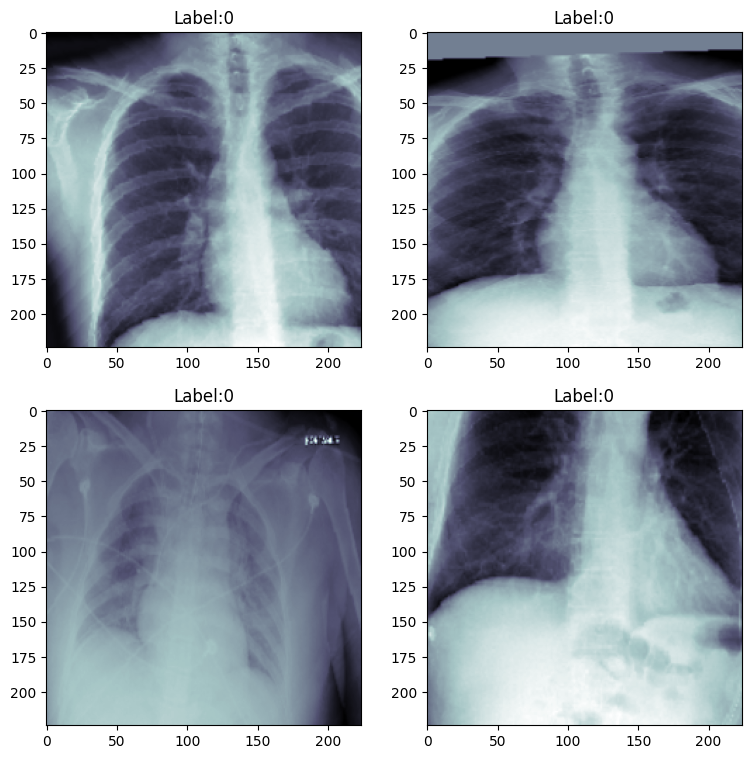

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1000)
        x_ray, label = train_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")



Inspect validation images

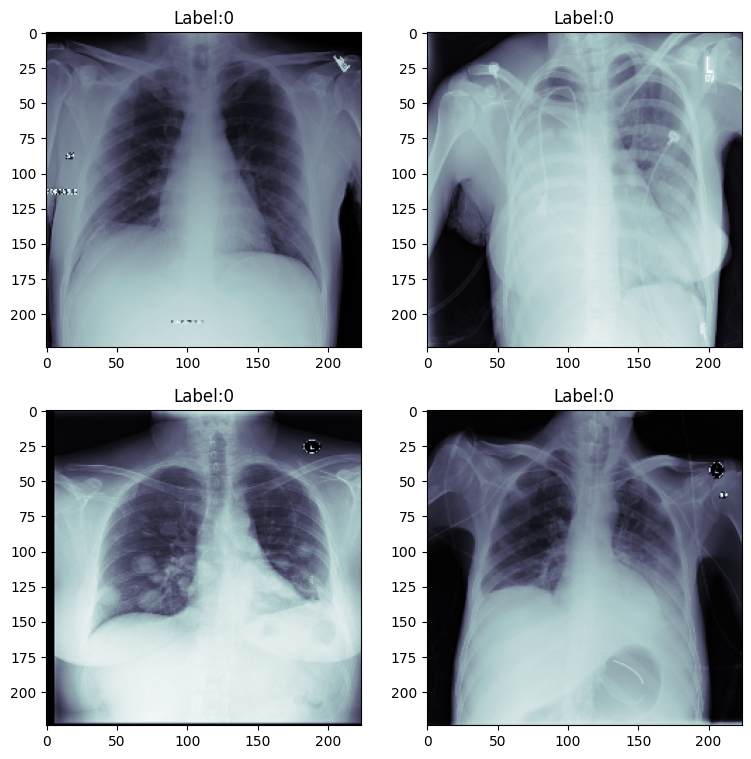

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1000)
        x_ray, label = val_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

Inspect test images

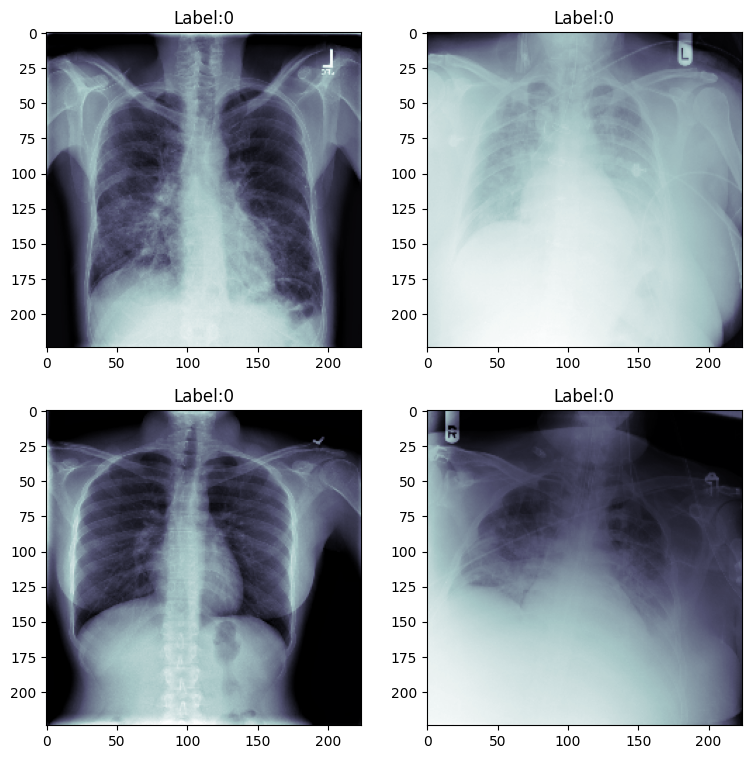

In [ ]:
fig, axis = plt.subplots(2, 2, figsize=(9, 9))
for i in range(2):
    for j in range(2):
        random_index = np.random.randint(0, 1000)
        x_ray, label = test_dataset[random_index]
        axis[i][j].imshow(x_ray[0], cmap="bone")
        axis[i][j].set_title(f"Label:{label}")

Create train, validation and test loader using train, validation and test dataset.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=False)

The classes are imbalanced: There are more images without signs of pneumonia than with pneumonia.
There are multiple ways to deal with imbalanced datasets:
* Weighted Loss
* Oversampling
* Doing nothing

For this research, weighted loss is adopted.

In train dataset, non-pneumonia images are three time the pneumonia images. Therefore weight loss that is used in the research is 3.

In [ ]:
np.unique(train_dataset.targets, return_counts=True), np.unique(val_dataset.targets, return_counts=True)

((array([0, 1]), array([14452,  4748])), (array([0, 1]), array([2079,  605])))

## WRN-101-2 Model Creation in pytorch lightning

Each pytorch lightning model is defined by at least an initialization method, a **forward** function which defines the forward pass/prediction, a **training_step** which yields the loss and **configure_optimizers** to specify the optimization algorithm.

Additionally, **on_train_epoch_end** callback is used to compute overall dataset statistics and metrics such as accuracy and loss.

Subsequently, **validation_step** is defined. The validation step performs more or less the same steps as the training step, however, on the validation data. In this case, pytorch lightning doesn't update the weights.
Again, **on_validation_epoch_end** can be used to compute overall dataset metrics.

No loops or manual weight updates are needed!<br />
Additionally, pl also handles device management.  Just pass the number of GPUS when creating the trainer.

**Model Creation** - WRN-101-2 (Wide_resnet101_2) network architecture is used.

As most of the torchvision models, the original WRN-101-2 expects a three channel input in **conv1**. <br />
However, the X-Ray image data has only one channel. Thus, the in_channel parameter needs to be changed from 3 to 1.

Additionally, the last fully connected layer will be changed to have only one output since there is a binary class label.

### Optimizer and Loss
The Adam optimizer is used with a learning rate of 0.001 and the BinaryCrossEntropy loss function.
(In fact, BCEWithLogitsLoss is used, which directly accepts the raw unprocessed predicted values and computes the sigmoid activation function before applying Cross Entropy.).


In [ ]:
class WideResNet101_2(pl.LightningModule):
    def __init__(self, weight=3.0):
        super(WideResNet101_2, self).__init__()
        #For PRETRAINED MODEL:  set the pretrained to True else false
        self.model = torch.hub.load('pytorch/vision:v0.10.0', 'wide_resnet101_2', pretrained=True)
        self.model.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        self.model.fc = nn.Linear(in_features=2048, out_features=1, bias=True)

        # self.optimizer = optim.Adam(self.model.parameters(), lr=0.01, weight_decay=1e-4)
        self.optimizer  = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([3.0]))

        # simple accuracy computation
        self.train_acc = BinaryAccuracy()
        self.val_acc = BinaryAccuracy()

        self.training_avg_acc_logger = []
        self.training_avg_loss_logger = []
        self.training_acc_logger = []
        self.training_loss_logger = []

        self.validation_avg_acc_logger = []



    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x_ray, label = batch
        label = label.float()  # Convert label to float (just needed for loss computation)
        pred = self(x_ray)[:,0]  # Prediction: Make sure prediction and label have same shape
        loss = self.loss_fn(pred, label)  # Compute the loss

        # Log loss and batch accuracy
        self.training_loss_logger.append(loss.item())
        self.train_acc(torch.sigmoid(pred), label.int())
        return loss

    def on_train_epoch_end(self):
        # After one epoch compute the whole train_data accuracy
        self.training_avg_loss_logger.append(sum(self.training_loss_logger)/len(self.training_loss_logger))
        self.training_avg_acc_logger.append(self.train_acc.compute().item())

        print("Train Acc", self.train_acc.compute().item())
        print("Train Loss:", sum(self.training_loss_logger)/len(self.training_loss_logger))
        self.train_acc.reset()
        self.training_loss_logger = []

    def validation_step(self, batch, batch_idx):
        # Same steps as in the training_step
        x_ray, label = batch
        label = label.float()
        pred = self(x_ray)[:,0]  # make sure prediction and label have same shape
        self.val_acc(torch.sigmoid(pred), label.int())

    def on_validation_epoch_end(self):
        print("Val Acc",self.val_acc.compute())
        self.validation_avg_acc_logger.append(self.val_acc.compute().item())
        self.val_acc.reset()


    def configure_optimizers(self):
        #Caution! You always need to return a list here (just pack your optimizer into one :))
        return [self.optimizer]

In [ ]:
model101_2 = WideResNet101_2(weight=3.0)  # Instanciate the model

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Trainer documentation: https://pytorch-lightning.readthedocs.io/en/latest/common/trainer.html

Create Model checkpoint callback to save the model after every 10 epochs

In [ ]:
every_n_epochs = 10
checkpoint_callback = ModelCheckpoint(
        # dirpath=checkpoints_path, # <--- specify this on the trainer itself for version control
        filename="wrn-101-2-2_classifier_{epoch:02d}",
        every_n_epochs=every_n_epochs,
        save_top_k=-1,  # <--- this is important!
    )

Create the trainer using model checkpoint

In [ ]:
trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    default_root_dir=checkpoint_path,
    max_epochs=num_epochs)
print(num_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


60


In [ ]:
# Fit / Train the model using train loader and val loader
trainer.fit(model101_2, train_loader, val_loader)

INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA L4') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name      | Type              | Params | Mode 
--------------------------------------------------------
0 | model     | ResNet            | 124 M  | train
1 | loss_fn   | BCEWithLogitsLoss | 0      | train
2 | train_acc | BinaryAccuracy    | 0      | train
3 | val_acc   | BinaryAccuracy    | 0      | train
--------------------------------------------------------
124 M     Trainable params
0         Non-trainable params
124 M     Total params
499.334   Total estimated 

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Val Acc tensor(1., device='cuda:0')


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7776, device='cuda:0')
Train Acc 0.7215625047683716
Train Loss: 0.8406018656492233


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7858, device='cuda:0')
Train Acc 0.746874988079071
Train Loss: 0.7702605743209521


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7910, device='cuda:0')
Train Acc 0.7635416388511658
Train Loss: 0.724751071035862


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7392, device='cuda:0')
Train Acc 0.7632291913032532
Train Loss: 0.7168907881776492


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7291, device='cuda:0')
Train Acc 0.7750520706176758
Train Loss: 0.6823726943135262


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8148, device='cuda:0')
Train Acc 0.7761979103088379
Train Loss: 0.6749705874919891


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8230, device='cuda:0')
Train Acc 0.7803124785423279
Train Loss: 0.6723522705833117


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8081, device='cuda:0')
Train Acc 0.7799999713897705
Train Loss: 0.6564343760410944


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8040, device='cuda:0')
Train Acc 0.7955729365348816
Train Loss: 0.6266927016774814


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7850, device='cuda:0')
Train Acc 0.7944270968437195
Train Loss: 0.6226182548205058


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8167, device='cuda:0')
Train Acc 0.7990624904632568
Train Loss: 0.6141867838303248


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7489, device='cuda:0')
Train Acc 0.8016666769981384
Train Loss: 0.6051136108239492


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8051, device='cuda:0')
Train Acc 0.8103125095367432
Train Loss: 0.5868369337916374


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8085, device='cuda:0')
Train Acc 0.8145833611488342
Train Loss: 0.583820466697216


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8230, device='cuda:0')
Train Acc 0.8165624737739563
Train Loss: 0.5707817094524702


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8141, device='cuda:0')
Train Acc 0.8182812333106995
Train Loss: 0.5582516351342202


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8118, device='cuda:0')
Train Acc 0.8224478960037231
Train Loss: 0.5444907959302266


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8227, device='cuda:0')
Train Acc 0.8263021111488342
Train Loss: 0.5384017341335614


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7444, device='cuda:0')
Train Acc 0.835156261920929
Train Loss: 0.5166331220666568


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8510, device='cuda:0')
Train Acc 0.8368229269981384
Train Loss: 0.5109994476040204


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8264, device='cuda:0')
Train Acc 0.8394791483879089
Train Loss: 0.5008844573795795


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7966, device='cuda:0')
Train Acc 0.8451041579246521
Train Loss: 0.48997645646333693


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8033, device='cuda:0')
Train Acc 0.8463541865348816
Train Loss: 0.4773707450926304


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7705, device='cuda:0')
Train Acc 0.8576562404632568
Train Loss: 0.4620884278913339


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8290, device='cuda:0')
Train Acc 0.856249988079071
Train Loss: 0.4563825346032778


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8189, device='cuda:0')
Train Acc 0.8636458516120911
Train Loss: 0.4388368373612563


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7813, device='cuda:0')
Train Acc 0.868177056312561
Train Loss: 0.43963150228063264


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8189, device='cuda:0')
Train Acc 0.8693228960037231
Train Loss: 0.4229824497302373


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8141, device='cuda:0')
Train Acc 0.8729687333106995
Train Loss: 0.4065184018512567


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7493, device='cuda:0')
Train Acc 0.8794270753860474
Train Loss: 0.39308195571104687


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7839, device='cuda:0')
Train Acc 0.8778645992279053
Train Loss: 0.3958069690068563


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8383, device='cuda:0')
Train Acc 0.883593738079071
Train Loss: 0.37826461484034857


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8018, device='cuda:0')
Train Acc 0.8913541436195374
Train Loss: 0.3640003098050753


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8260, device='cuda:0')
Train Acc 0.8960937261581421
Train Loss: 0.34571033594508965


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7083, device='cuda:0')
Train Acc 0.9015104174613953
Train Loss: 0.34041736913224063


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8174, device='cuda:0')
Train Acc 0.901354193687439
Train Loss: 0.328277970602115


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7820, device='cuda:0')
Train Acc 0.9058333039283752
Train Loss: 0.32539012489219504


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8159, device='cuda:0')
Train Acc 0.9098437428474426
Train Loss: 0.3127126124004523


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8159, device='cuda:0')
Train Acc 0.9112499952316284
Train Loss: 0.29677981056272984


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8241, device='cuda:0')
Train Acc 0.9155208468437195
Train Loss: 0.29315105405946573


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8130, device='cuda:0')
Train Acc 0.918958306312561
Train Loss: 0.28162531157334647


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8342, device='cuda:0')
Train Acc 0.9246354103088379
Train Loss: 0.2650703322639068


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7943, device='cuda:0')
Train Acc 0.9215103983879089
Train Loss: 0.2763585368047158


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8122, device='cuda:0')
Train Acc 0.9261458516120911
Train Loss: 0.2570797502497832


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8174, device='cuda:0')
Train Acc 0.9310937523841858
Train Loss: 0.24485678317646187


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7757, device='cuda:0')
Train Acc 0.9349479079246521
Train Loss: 0.2345923864468932


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8107, device='cuda:0')
Train Acc 0.9339062571525574
Train Loss: 0.232755741973718


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8264, device='cuda:0')
Train Acc 0.9355208277702332
Train Loss: 0.22709560804069043


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8335, device='cuda:0')
Train Acc 0.9396353960037231
Train Loss: 0.21420560363059243


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8100, device='cuda:0')
Train Acc 0.9371353983879089
Train Loss: 0.21831048638870318


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.7534, device='cuda:0')
Train Acc 0.9459375143051147
Train Loss: 0.19699323722471793


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8059, device='cuda:0')
Train Acc 0.9424479007720947
Train Loss: 0.2064477280403177


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8070, device='cuda:0')
Train Acc 0.94942706823349
Train Loss: 0.18327604836473863


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8085, device='cuda:0')
Train Acc 0.94552081823349
Train Loss: 0.19725500280658403


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8152, device='cuda:0')
Train Acc 0.9485416412353516
Train Loss: 0.18824902083724737


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8349, device='cuda:0')
Train Acc 0.9505729079246521
Train Loss: 0.17820149858792622


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8286, device='cuda:0')
Train Acc 0.9505208134651184
Train Loss: 0.17999609731137753


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8383, device='cuda:0')
Train Acc 0.9580729007720947
Train Loss: 0.15960276906689008


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8249, device='cuda:0')
Train Acc 0.956458330154419
Train Loss: 0.1662952100361387


Validation: |          | 0/? [00:00<?, ?it/s]

Val Acc tensor(0.8212, device='cuda:0')
Train Acc 0.9577603936195374
Train Loss: 0.156048438573877


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


Save the trained model

In [ ]:
torch.save(model101_2, model_save_path)

## Evaluation

Put the model to evaluation and move it to the device

In [ ]:
model101_2.eval()
model101_2.to(device);

Text(0.5, 1.0, 'WideResNet 101-2 Training Loss')

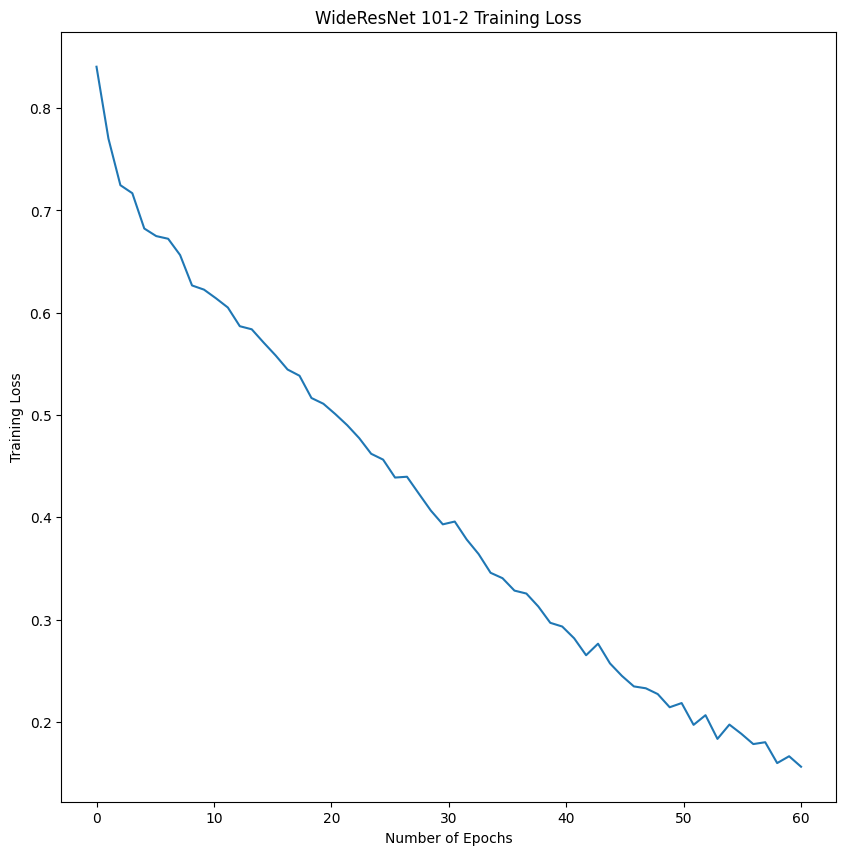

In [ ]:
#Plot the graph for Training loss over the epochs
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(model101_2.training_avg_loss_logger))
plt.plot(train_x, model101_2.cpu().training_avg_loss_logger)
plt.xlabel('Number of Epochs')
plt.ylabel('Training Loss')
plt.title("WideResNet 101-2 Training Loss")

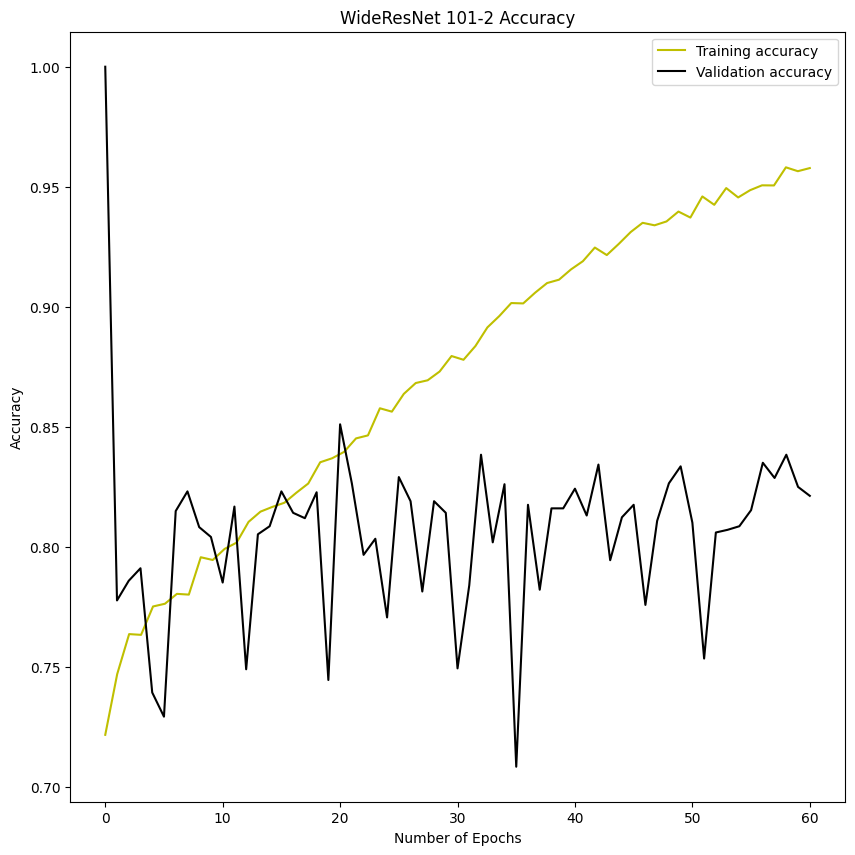

In [ ]:
#Plot the graph for Tranining and validation accuracy over number of epochs
plt.figure(figsize = (10,10))
train_x = np.linspace(0, num_epochs, len(model101_2.training_avg_acc_logger))
plt.plot(train_x, model101_2.training_avg_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model101_2.validation_avg_acc_logger))
plt.plot(valid_x, model101_2.validation_avg_acc_logger, c = "k")
plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title("WideResNet 101-2 Accuracy")
plt.legend(["Training accuracy", "Validation accuracy"])

Compute prediction on the complete validation set and store predictions and labels

In [ ]:
preds = []
labels = []
model101_2.to(device);
with torch.no_grad():
    for data, label in tqdm(test_dataset):
        data = data.to(device).float().unsqueeze(0)
        pred = torch.sigmoid(model101_2(data).cpu())
        preds.append(pred)
        labels.append(label)
preds = torch.tensor(preds)
labels = torch.tensor(labels).int()

  0%|          | 0/4800 [00:00<?, ?it/s]

Print the performance metrics for test data

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve, auc
all_labels = np.array(labels)
all_preds = np.array(preds)
auc_score = roc_auc_score(all_labels, all_preds)
acc = BinaryAccuracy()( preds, labels)
precision = torchmetrics.Precision(task='binary')( preds, labels)
recall = torchmetrics.Recall(task='binary')( preds, labels)
f1 = torchmetrics.F1Score(task='binary')( preds, labels)
cm = torchmetrics.ConfusionMatrix(task='binary', num_classes=2)(preds, labels)
print(f"Accuracy: {acc}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"AUC: {auc_score}")
print(f"Confusion Matrix: {cm}")

Accuracy: 0.8066666722297668
Precision: 0.38911789655685425
Recall: 0.7162367105484009
F1 Score: 0.504273533821106
AUC: 0.8647292206181274
Confusion Matrix: tensor([[3400,  741],
        [ 187,  472]])


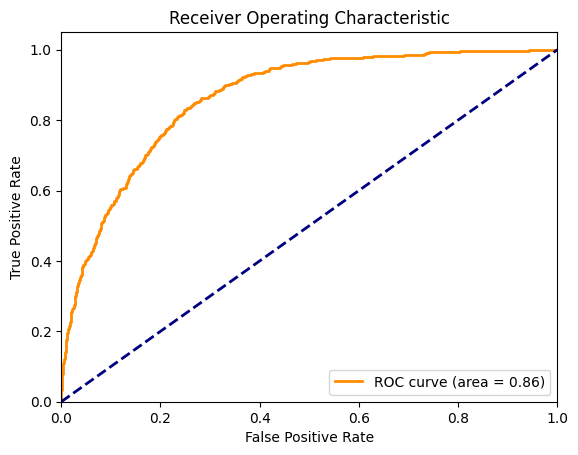

In [ ]:
# Plot the AUC-ROC curve
from sklearn.metrics import roc_auc_score, roc_curve, auc
all_labels = np.array(labels)
all_preds = np.array(preds)
fpr, tpr, _ = roc_curve(all_labels, all_preds)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

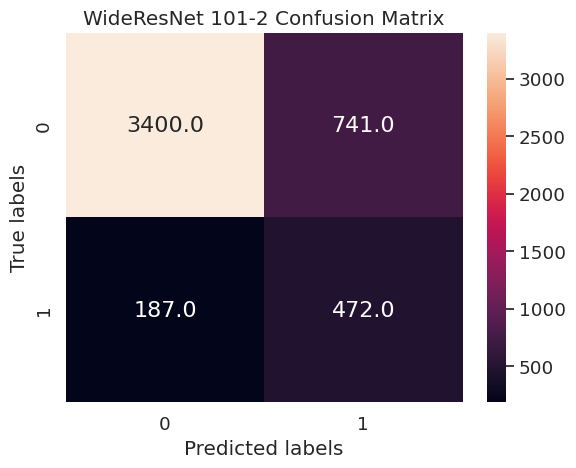

In [ ]:
# Plot the confusion matrix
df_cm = pd.DataFrame(cm.numpy(), range(2), range(2))

sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True,fmt=".1f", annot_kws={"size": 16}) # font size

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('WideResNet 101-2 Confusion Matrix')

plt.show()

# Model Interpretability

Defining a class for Score-CAM interpretability.

In [ ]:
# define class for Score-CAM
"""
PyTorch implementation of Score-CAM.
"""

# Import standard libraries.
import copy

# Import third-party packages.
import numpy as np
import torch


class ScoreCAM:
    """
    PyTorch implementation of Score-CAM [1].

    References:
        [1] H. Wang, Z. Wang, M. Du, F. Yang, Z. Zhang, S. Ding, P. Mardziel, and X. Hu,
            "Score-CAM: Score-weighted visual explanations for convolutional neural networks",
            CVPR, 2020.
    """
    def __init__(self, model, actmap, device="cpu"):
        """
        Constructor.

        Args:
            model  (torch.nn.Module): Target NN model.
            actmap (str)            : Name of layer to extract activation maps.
            device (str)            : Device name ("cpu" or "cuda").
        """
        # Copy the target NN model and prepare it.
        self.model = copy.deepcopy(model.to("cpu"))
        self.model.to(device)
        self.model.eval()

        # Register a hook function to extract activation maps.
        getattr(self.model, actmap).register_forward_hook(self.hook)

    def hook(self, module, x_in, x_out):
        """
        Hook function to extract activation maps.
        This function is assumed to be registered to NN layer.

        Args:
            module (torch.nn.Module): Target layer.
            x_in   (torch.Tensor)   : Input tensor of the layer.
            x_out  (torch.Tensor)   : Output tensor of the layer.
        """
        self.activation_map = x_out.detach().to("cpu")

    def compute(self, X, coi, batch_size=128, cskip=False, cskip_out=16):
        """
        Compute visual explanation.

        Args:
            X          (np.ndarray or torch.Tensor): Input image.
            coi        (int or Callable)           : Class of interest.
            batch_size (int)                       : Batch size.
            cskip      (bool)                      : Enable CSKIP optimization.
            cskip_out  (int)                       : Output channels of the CSKIP.

        Returns:
            (torch.Tensor): 2D array of visual explanation.
        """
        # Define a scoring function.
        if isinstance(coi, int):
            self.scoring_fn = lambda output: output[:, coi]
        elif hasattr(coi, "__call__"):
            self.scoring_fn = coi

        # Verify the data type of the input array.
        if (type(X) != np.ndarray) and (type(X) != torch.Tensor):
            raise TypeError("input array should be NumPy or PyTorch array.")

        # Get device.
        device = next(self.model.parameters()).device

        # Convert the input tensor to torch.Tensor on CPU.
        X = torch.Tensor(X).to("cpu")
        X = X.unsqueeze(0)
        # Reshape the input tensor to (B, C, H, W).
        # X, (B, C, H, W) = reshape_input_tensor(X)
        X, (B,C,H,W) = X, X.shape
        print(X.shape, B, C, H, W)

        # Run inference and get activation maps. The activation maps are
        # acquired by the hook function registered in the __init__ function.
        with torch.no_grad():
            p = self.model(X.to(device))

        # Get the reference score.
        s_ref = self.scoring_fn(p.to("cpu"))

        # Apply CSKIP if specified.
        if cskip: A = channel_skipping(self.activation_map, cskip_out)
        else    : A = self.activation_map

        # Get the channel number of the activation maps.
        # Note that the activation maps are always on CPU.
        K = A.shape[1]

        # Upsample the activation maps and change the dimension order
        # from [1, K, H, W] to [K, 1, H, W].
        A = torch.nn.functional.interpolate(A, (H, W), mode="bicubic")
        A = torch.permute(A, [1, 0, 2, 3])

        # Normalize the activation maps.
        self.A_normalized = normalize_activation_map(A)

        # Compute the masked images.
        self.M = X * self.A_normalized

        # Initialize the list of predictions.
        batch_p = list()

        for batch_idx_bgn in range(0, K, batch_size):

            # Get input batch.
            M_batch = self.M[batch_idx_bgn:batch_idx_bgn+batch_size, :, :, :]

            # Run inference to get the predictions.
            with torch.no_grad():
                p = self.model(M_batch.to(device))

            # Add predictions to the list.
            batch_p.append(p.to("cpu"))

        p = torch.concat(batch_p, dim=0)
        A = A.to("cpu")
        X = X.to("cpu")

        # Compute the CIC score for the activation maps.
        s = self.scoring_fn(p) - s_ref
        a = torch.nn.functional.softmax(s, dim=0)
        a = a.reshape([-1, 1, 1])

        # The tensor A should have the shape [C, 1, H, W] at this moment.
        # Change the shape to [C, H, W] for the following summation.
        A = torch.squeeze(A, dim=1)

        # Compute the visual explanation.
        L = torch.nn.functional.relu(torch.sum(a * A.reshape([K, H, W]), dim=0))

        # Returns as NumPy array.
        return L.numpy()

    @staticmethod
    def to_colormap(X, normalize=True):
        """
        Convert input 2D array to a color heat map.

        Args:
            X         (np.ndarray): Input array.
            normalize (bool)      : Normalize the input array if True.

        Returns:
            (np.ndarray): Color heat map.
        """
        # Normalize if specified.
        if normalize:
            X = (X - np.min(X)) / (np.max(X) - np.min(X))
            X = np.clip(255 * X, 0, 255).astype(np.uint8)

        # Create JET color map.
        CMAP = np.zeros([256, 3], dtype=np.uint8)
        for i in range(256):
            if   i <  32: j = i -   0; CMAP[i, :] = (      0,       0, 127+4*j)
            elif i <  96: j = i -  32; CMAP[i, :] = (      0,     4*j,     255)
            elif i < 160: j = i -  96; CMAP[i, :] = (    4*j,     255, 255-4*j)
            elif i < 224: j = i - 160; CMAP[i, :] = (    255, 255-4*j,       0)
            else        : j = i - 224; CMAP[i, :] = (255-4*j,       0,       0)

        # Apply the JET color map.
        Y = np.stack([CMAP[X, 0], CMAP[X, 1], CMAP[X, 2]], axis=2)

        return Y

    @staticmethod
    def overlay(image, L):
        """
        Overlay the given visual explanation to the given image.

        Args:
            image (np.ndarray or torch.Tensor): Input image with shape (H, W, C).
            L     (np.ndarray or torch.Tensor): Visual explanation with shape (H, W).

        Returns:
            (np.ndarray): Overlay image with shape (H, W, C).
        """
        # Convert the image and the visual explanation to NumPy array.
        if isinstance(image, torch.Tensor):
            image = image.numpy()
        if isinstance(L, torch.Tensor):
            L = L.numpy()

        M = ScoreCAM.to_colormap(L)
        return np.clip(0.5 * image + 0.5 * M, 0, 255).astype(np.uint8)


def reshape_input_tensor(X):
    """
    Reshape input tensor to shape (B, C, H, W) where B is always 1.

    Args:
        X (torch.Tensor): Input array.

    Returns:
        (tuple): A tuple of (reshaped array, shape of the array).
    """
    # Case 1: X.shape == (H, W)
    if len(X.shape) == 2:

        # Get array shape.
        H, W = X.shape

        # Reshape to (B, C, H, W).
        X = X.reshape((1, 1, H, W))

        return (X, (1, 1, H, W))

    # Case 2: X.shape == (H, W, C)
    elif len(X.shape) == 3:

        # Get array shape.
        H, W, C = X.shape

        # Reshape to (B, C, H, W).
        X = torch.permute(X, [2, 0, 1])
        X = X.reshape((1, C, H, W))

        return (X, (1, C, H, W))

    # Case 3: X.shape == (1, C, H, W)
    elif len(X.shape) == 4:

        # Verify the batch size is one.
        if X.shape[0] != 1:
            raise ValueError("Batch size should be 1")

        return (X, X.shape)

    else:
        raise ValueError("Unexpected input shape: %s" % str(X.shape))


def normalize_activation_map(A, eps=1.0E-10):
    """
    Normalize the given activation map.

    Args:
        A   (np.ndarray): Activation map with shape (K, 1, H, W).
        eps (float)     : Small value to prevent zero division.

    Returns:
        (np.ndarray): Normalized activation map.
    """
    # Compute min/max of each channel.
    A_min, _ = torch.min(torch.flatten(A, start_dim=2), dim=2)
    A_max, _ = torch.max(torch.flatten(A, start_dim=2), dim=2)

    # Reshape the min/max array to the shape (K, 1, 1, 1).
    A_min = A_min.reshape([-1, 1, 1, 1])
    A_max = A_max.reshape([-1, 1, 1, 1])

    # Normalize the activation map.
    return (A - A_min) / (A_max - A_min + eps)


def channel_skipping(A, cskip_out=16):
    """
    CSKIP optimization.

    Args:
        A         (torch.Tensor): Activation maps.
        cskip_out (int)         : Number of output channels.
    """
    # Compute max value of each channel.
    A_max, _ = torch.max(torch.flatten(A, start_dim=2), dim=2)

    # Sort channels by the max value.
    idx_max = torch.argsort(A_max.reshape([-1]), descending=True)

    return A[:, idx_max[:cskip_out], :, :]

Load the saved model

In [ ]:
# model101_2 = torch.load(model_save_path)
# print(model101_2)
# model101_2.eval()

WideResNet101_2(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

WideResNet101_2(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential

Create scoreCAM instance by providing the internal model (not the wrapper object)

In [ ]:
scorecam = ScoreCAM(model101_2.model, actmap="layer4", device="cuda")

In [ ]:
# load the numpy image of positive case of pneumonia.
# img = np.load("/content/00436515-870c-4b36-a041-de91049b9ab4.npy")
# img = torch.from_numpy(img).float().unsqueeze(0)
# print(img.shape)

torch.Size([1, 224, 224])


In [ ]:
# load the numpy image of positive case of pneumonia from validation dataset.
img = val_dataset[-6][0]
print(img.shape)

torch.Size([1, 224, 224])


In [ ]:
L = scorecam.compute(img, coi=0)
print(L.shape)

torch.Size([1, 1, 224, 224]) 1 1 224 224
(224, 224)


In [ ]:
# reshape the from (1 x 224 x 224) to (224 x 224 x 1)
cv2_image = img.reshape(224,224,1)
print(cv2_image.shape)

torch.Size([224, 224, 1])


In [ ]:
# predict the image using the trained model
img_input = img.unsqueeze(0)
pred = torch.sigmoid(model101_2(img_input))
print(pred)

tensor([[0.9699]], grad_fn=<SigmoidBackward0>)


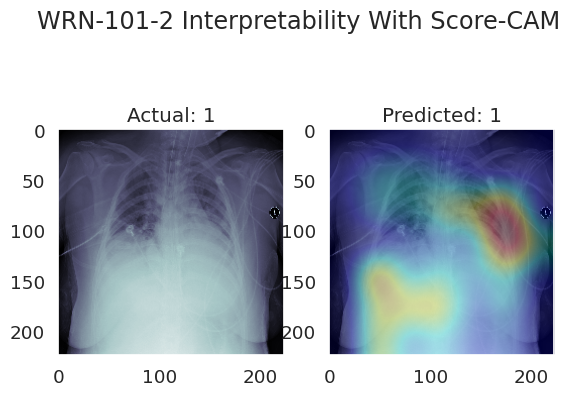

In [ ]:
# Create the overlay heatmap for the target image
image_overlay = scorecam.overlay(cv2_image, L)
# plot the image with the generated scoreCAM overlay
fig, axis = plt.subplots(1,2)
fig.suptitle('WRN-101-2 Interpretability With Score-CAM')
axis[0].imshow(cv2_image, cmap="bone")
axis[0].set_title("Actual: 1")
axis[0].xaxis.grid(False, which='major')
axis[0].yaxis.grid(False, which='major')

axis[1].imshow(cv2_image, cmap="bone")
axis[1].imshow(image_overlay, alpha=0.5, cmap="jet")
axis[1].set_title(f"Predicted: 1")
axis[1].xaxis.grid(False, which='major')
axis[1].yaxis.grid(False, which='major')